# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.article_id = df.article_id.astype('str')

# Show df to get an idea of the data
df.head()


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [42]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [43]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(df.groupby('email').count().article_id) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.email.value_counts()[0] # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [44]:
# Find and explore duplicate articles
df_content[df_content.article_id.duplicated(keep='first')].head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [45]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [46]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [47]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().max() # The most viewed article in the dataset was viewed how many times?

In [48]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

In [49]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [50]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_ids = np.array(df.article_id.value_counts().index[:n])
    top_articles = df[df.article_id.isin(top_articles_ids[:n])].title.unique()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_ids = np.array(df.groupby('article_id').count().sort_values(by='title', ascending=False).reset_index().article_id[:n])
 
    return top_articles_ids # Return the top article ids

In [51]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


In [52]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [53]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - pandas dataframe user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    df = df.sort_values(by='user_id', ascending=True)

    # extract user_id and article_id columns from the df for faster processing
    df_user_id = df.user_id
    df_user_id_num = df_user_id.nunique()
    df_article_id = df.article_id.astype('str')

    u_ids_seen = []
    
    # Empty dict. 
    # Eventually this dict will hold the article_ids as keys and a array of length number of users as values
    # the value array contains 1's and 0's for users who have interacted with the article and otherwise respectively
    user_item_dict = dict()
    
    idx = -1;
    
    for u_id, a_id in zip(df_user_id, df_article_id):
        if u_id not in u_ids_seen:
            u_ids_seen.append(u_id)
            idx += 1
            
        if a_id in user_item_dict:
            user_item_dict[a_id][idx] = 1
        else:
            # create empty array with number of unqiue users. The element will be set to 1 if there is an interaction
            user_item_dict[a_id] = np.zeros(df_user_id_num)
            user_item_dict[a_id][idx] = 1
        
        
    user_item = pd.DataFrame(user_item_dict, index=u_ids_seen)

    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

In [54]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [55]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    user_item_mat = np.matrix(user_item).getA()
    user_articles = user_item_mat[user_id - 1]

    sim = {user_id: 0}
    
    for u in user_item.index:
        if u != user_id:
            sim[u] = np.dot(user_articles, user_item_mat[u - 1])
            
    sim = dict(sorted(sim.items(), key=lambda x: x[1], reverse=True))
    
    most_similar_users = list(sim.keys())
    
    return most_similar_users

    

In [56]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [57]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df.title[df.article_id.isin(article_ids)].unique().tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = user_item.columns[user_item.loc[user_id] == 1]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # get article id and names for the input users
    a_ids, a_names = get_user_articles(user_id)
    
    # find users similar to the input user
    similar_users = find_similar_users(user_id)
    
    recs = []
    
    # for each similar user, get articles and add the articles which are not there in the input users articles list
    for sim_user in similar_users:
        # articles ids and names of the similar user
        sim_a_ids, sim_a_names = get_user_articles(sim_user)

        # get difference of article between the similar user and input user
        new_a_ids = np.setdiff1d(a_ids, sim_a_ids)

        # add the difference articles as recommendations to the input user
        for new_a_id in new_a_ids:
            if new_a_id not in recs:
                recs.append(new_a_id)
                
                if len(recs) >= m:
                    break
        
        if len(recs) >= m:
            break

    return recs # return your recommendations for this user_id    


In [58]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['uci ml repository: chronic kidney disease data set',
 'time series prediction using recurrent neural networks (lstms)',
 'jupyter notebook tutorial',
 'uci: iris',
 'sector correlations shiny app',
 'country statistics: life expectancy at birth',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'categorize urban density',
 'predict loan applicant behavior with tensorflow neural networking']

In [60]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [61]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    user_item_mat = np.matrix(user_item).getA()
    user_articles = user_item_mat[user_id - 1]
    num_interactions = np.array(df.groupby('user_id').count().drop(columns='title')).flatten()
    neighbours = np.array([user_id, 0, df.user_id.value_counts()[user_id]])
    
    for u in user_item.index:
        if u != user_id:
           neighbours = np.vstack((neighbours, np.array([u, np.dot(user_articles, user_item_mat[u - 1]), num_interactions[u - 1]])))

    
    neighbours_df = pd.DataFrame(neighbours, columns=['neighbour_id', 'similarity', 'num_interactions'])

    # remove the own user's id
    neighbours_df.drop(index=user_id, inplace=True)
    
    # sort by similarity
    neighbours_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)

    return neighbours_df
    
    '''
    total_users = user_item.shape[0]
    
    user_articles = user_item.loc[user_id]

    neighbors_df = pd.DataFrame(data={'neighbor_id' : user_id, 'similarity': 0, 'num_interactions': df.user_id.value_counts()[user_id]}, index=[user_id])
    
    # For every other user, store a dot product of the user articles with the input user's articles, that will give us how similar every user is with the input user
    for u in user_item.index:
        if u != user_id:
            d = pd.DataFrame(data={'neighbor_id' : u, 'similarity': np.dot(user_articles, user_item.loc[u]), 'num_interactions': df.user_id.value_counts()[u]}, index=[u])
            neighbors_df = neighbors_df.append(d)
            
    # remove the own user's id
    neighbors_df.drop(index=user_id, inplace=True)
    
    # sort by similarity
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string
    '''

def get_sorted_articles(article_ids, df=df):
    
    return df[df.article_id.isin(article_ids)].article_id.value_counts().index
    

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # articles id and names for the input user
    a_ids_user, a_names_user = get_user_articles(user_id)
    
    # neighbours of the input user sorted by similarity
    neighbours_df = get_top_sorted_users(user_id)
    
    recs = []
    rec_names = []
    
    #for each neighbour, get articles and add the articles which are not there in the input users articles list
    for n in neighbours_df.index:
        if (n != user_id):
            # articles ids and names of the neighbour
            a_ids_n, a_names_n = get_user_articles(n)
            
            # get difference of article between the neighbour and input user
            a_ids = np.setdiff1d(a_ids_n, a_ids_user, assume_unique=True)
            
            # add the difference articles as recommendations to the input user
            if a_ids is not None:
                new_a_ids = get_sorted_articles(a_ids)
                new_a_names = get_article_names(new_a_ids)
            
                for new_a_id, new_a_name in zip(new_a_ids, new_a_names):
                    recs.append(new_a_id)
                    rec_names.append(new_a_name)

                    if len(recs) >= m:
                        break;

            if len(recs) >= m:
                break;
                
    
    return recs, rec_names

In [62]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1170.0', '1436.0', '1160.0', '1336.0', '1165.0', '1172.0', '1276.0', '1430.0', '1163.0']

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'deploy your python model as a restful api', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'apache spark lab, part 1: basic concepts', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'welcome to pixiedust', 'insights from new york car accident reports', 'analyze open data sets with spark & pixiedust']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [63]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbour_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbour_id # Find the 10th most similar user to user 131

In [64]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Thoughts**

Recommendations of the new user using the above methods would be totally random. Since the user does not have a history on the platform it would be not be possible to get similar users to him based on historical data.

A better way would be to initially recommend the most popular articles i.e. articles with the most interactions and then recommend as per the users interactions with the articles on the platform.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [65]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)# Your recommendations here

new_user_recs

array(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0',
       '1293.0', '1170.0', '1162.0', '1304.0'], dtype=object)

In [66]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [69]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [70]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [71]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


**Thoughts**

In the lesson the the user item matrix was based on the rating of the user for the item. So if the user did not use the item the rating was a 'Not Applicable' leading to a null value.

In this case the user item matrix is based on whether or not a user has interacted with an article. So if a user did not interact with the article a value of '0' is stored which is still relevant to the matrix and not a null value.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

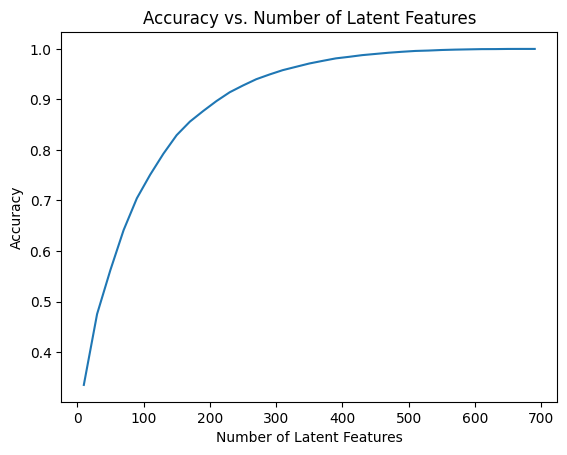

In [72]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [73]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user item matrix from the df_train dataframe
    user_item_train = create_user_item_matrix(df_train)
    
    # create user item matrix from the df_test dataframe
    user_item_test = create_user_item_matrix(df_test)
    
    # extract the index as ids (user ids)
    test_idx = np.array(user_item_test.index)
    
    # extract the columns as article_ids
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [74]:
# Number of User ids for whom we can predict using the train data.
len(np.intersect1d(df_test.user_id, df_train.user_id))

# Number of User ids for whom we have the cold start problem
len(np.setdiff1d(df_test.user_id, df_train.user_id))

# Number of articles id for whom can predict using the train data
len(np.intersect1d(df_test.article_id, df_train.article_id))

# Number of article ids for whom we have the cold start problem
len(np.setdiff1d(df_test.article_id, df_train.article_id))

0

In [75]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d, # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [76]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices = False) # fit svd similar to above then use the cells below

u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [77]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

u_test.shape, vt_test.shape

((20, 714), (714, 574))

In [78]:
# getting the user id for whom we can make predictions
test_user_ids = np.intersect1d(user_item_test.index, user_item_train.index)

# geting the article id for who we can make predictions
test_article_ids = np.intersect1d(user_item_test.columns, user_item_train.columns)

# getting subset of user_item dataframe for whom we can make predictions
valid_user_item = user_item.loc[test_user_ids, test_article_ids]


In [79]:
from sklearn.metrics import f1_score

num_latent_feats = np.arange(10, 700+10, 20)

all_ks = []
all_train_errs = []
all_test_errs = []

train_f1s = []
test_f1s = []

for k in num_latent_feats:
    u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    train_errs = user_item_train - train_preds
    all_train_errs.append(np.sum(np.sum(np.abs(train_errs))))
    
    train_f1s.append(f1_score(np.array(user_item_train).flatten(), train_preds.flatten(), average='weighted'))
    
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    test_errs = valid_user_item - test_preds
    all_test_errs.append(np.sum(np.sum(np.abs(test_errs))))
    
    test_f1s.append(f1_score(np.array(valid_user_item).flatten(), test_preds.flatten(), average='weighted'))
    
    all_ks.append(k)
    

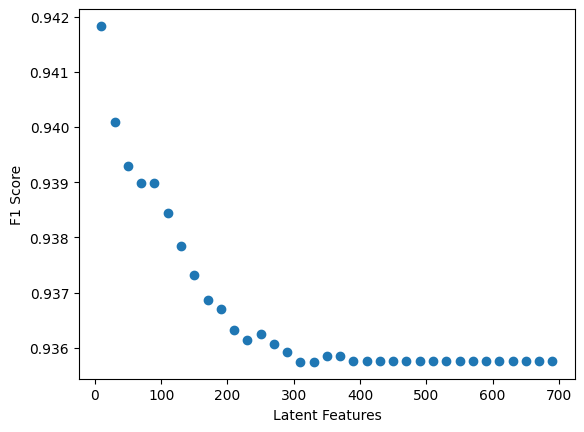

In [80]:
import seaborn as sns
plt.scatter(x=all_ks, y=test_f1s);
plt.xlabel('Latent Features');
plt.ylabel('F1 Score');

<a id='Assesment'>**Assesment**</a>

As seen from the plot, the optimum number of latent features for a high f1 score is around 100. We use the F1 score metric as a measure since the input data is imbalanced - Very few users have high number of interactions with the articles. Accuracy score would not be the correct metric.

Only 20 users in the test data could be used to recommend articles. 

To check if the recommendation system works it would be useful to try it out live for a predefined number of days to see if the recommendations actually have a 'click through' high enough for this system to be considered a success

In [81]:
# Recommend articlesto a user

def predict(user_id, u_train_new, vt_train_new):
    # get id to access the the row from the u_train_new matrix
    user_row_idx = np.where(user_item_train.index == user_id)[0]
    
    if len(user_row_idx) > 0:
        # get row which we can dot product the vt_train matrix to get possible user article interactions
        user_row = u_train_new[user_row_idx[0]]

        return np.dot(user_row, vt_train_new)
        
    return None
    
num_preds = 0
num_recs = 10

# Provide recommendations for every user in the test data
for user_id in test_idx:
    # Try to predict which article id the user might like.
    # predict returns None if the user is not found in the training dataset. means it is a new user. 
    # We cannot use SVD since there can be no similarity with any other user, so we recommend the top articles.
    
    pred = predict(user_id, u_train_new, vt_train_new)

    if pred is not None:
        # get the actual data for the user
        act = np.array(user_item_test.loc[user_id, :])
        num_preds += 1

        # get the sorted top <num_recs> indices from the pred array. These are article ids.
        indices = pred.argsort()[-num_recs:][::-1]
        
        # difference between the predicted and actual values.
        # a +ve high difference means the article id was not interacted with by the user and should be recommended.
        # a -ve different means the article id was interacted with by the user and need not be recommended.
        diff = pred[indices[indices < len(act)]] - act[indices[indices < len(act)]]
        
        print('Recommended articles for', user_id)
        print(df_train[df_train.article_id.isin(user_item_train.columns[indices])].title.unique())
        print('\n')
    else:
        (get_top_articles(10))


Recommended articles for 2917
['the nurse assignment problem'
 'an introduction to stock market data analysis with r (part 1)'
 'breast cancer wisconsin (diagnostic) data set'
 'sector correlations shiny app'
 'using machine learning to predict value of homes on airbnb'
 'why you should master r (even if it might eventually become obsolete)'
 'pearson correlation aggregation on sparksql'
 'using apply, sapply, lapply in r'
 'data visualization: the importance of excluding unnecessary details'
 'beyond parallelize and collect']


Recommended articles for 3024
['deep learning trends and an example'
 '1357    what i learned implementing a classifier from ...\nName: title, dtype: object'
 'interactive web apps with shiny cheat sheet'
 'sector correlations shiny app' 'blogging with brunel'
 'machine learning exercises in python, part 1'
 'spark-based machine learning tools for capturing word meanings'
 'machine learning for the enterprise.'
 'flightpredict ii: the sequel  – ibm watson data 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 